#  Photon shot noise dephasing
Gengyan Zhang, June 16 2016
## Reference
- This notebook simulates some of the experimental results in this paper: [Photon shot noise dephasing in the strong-dispersive limit of circuit QED](http://link.aps.org/doi/10.1103/PhysRevB.86.180504)
- Other papers on this topic:  
  [Qubit-photon interactions in a cavity: Measurement-induced dephasing and number splitting](http://link.aps.org/doi/10.1103/PhysRevA.74.042318)  
  [Using a qubit to measure photon-number statistics of a driven thermal oscillator](http://link.aps.org/doi/10.1103/PhysRevA.75.042302)  
  [Superconducting qubit in a waveguide cavity with a coherence time approaching 0.1 ms](http://link.aps.org/doi/10.1103/PhysRevB.86.100506) (Supplementary material)

In [1]:
%matplotlib inline
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, rfftfreq
from scipy.optimize import curve_fit
from IPython.display import Image

plt.rc('font', size=16)

## Photon number splitting of qubit spectrum
- Parameters: $\omega_q/2\pi$ = 6.655 GHz, $\chi/2\pi$ = -3.5 MHz, $\kappa/2\pi$ = 6 kHz, $T_1$ = 15 $\mu$s
- Hamiltonian (in rotating frame of drive): $H = (\omega_q-\omega_d)\frac{\sigma^z}{2} + \chi a^\dagger a\sigma^z + A_q(\sigma^++\sigma^-)$
- In the code below, sx[n] projects $\sigma^x$ to the $n$ photon subspace, so we can study qubit dephasing for individual photon numbers.

In [2]:
N = 20 # Truncate photon Hilbert space to dimension N
a = qt.tensor(qt.destroy(N), qt.qeye(2))
adag = a.dag()
sm = qt.tensor(qt.qeye(N), qt.sigmam())
sp = qt.tensor(qt.qeye(N), qt.sigmap())
sz = qt.tensor(qt.qeye(N), qt.sigmaz())
# sx[n] projects sigma^x to n photon subspace
sx = [qt.tensor(qt.basis(N, n)*qt.basis(N, n).dag(), qt.sigmax()) for
      n in range(0, N)]
# Frequencies in MHz, time in micro second
omegaQ = 6655.0*2.0*np.pi
chi = -3.5*2.0*np.pi  # (dispersive) qubit-cavity coupling rate
kappaR = 0.006*2.0*np.pi  # cavity decay rate
T1 = 15.0
gammaQ = 1.0/T1
numSteps = 2001

In [3]:
# Calcuate steady state <sigma^x> for a given qubit drive frequency and thermal photon number
def qubitSpec(deltaQ, nTh):
    ampQ = 0.2
    H = -deltaQ/2*sz + chi*adag*a*sz + ampQ*(sp+sm)
    c_ops = [np.sqrt(kappaR*(nTh+1.0))*a, np.sqrt(kappaR*nTh)*adag,
             np.sqrt(gammaQ)*sm]
    rho = qt.steadystate(H, c_ops, method='direct')
    return qt.expect(sz, rho)

# Sweep qubit drive frequency and thermal photon number
nthList = [0.0, 0.35, 2.0]
deltaList = np.linspace(4.5*chi, -0.5*chi, 501)
# Calculate steady state <sigma^x> for all nth and delta
szList = [np.array(qt.serial_map(qubitSpec, deltaList, task_args=(nth,))) for nth in nthList]
# qutip.parallel_map might not work for Windows
# szList = [np.array(qt.parallel_map(qubitSpec, deltaList, task_args=(nth,))) for nth in nthList]
textList = [r'$\bar{n}}$ = %.2f' % nth for nth in nthList]
colorList = ['b', 'g', 'r']
freqList = (omegaQ + deltaList)/(2.0*np.pi)/1e3

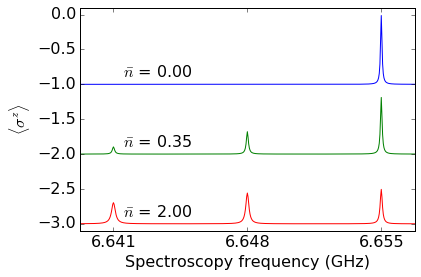

In [4]:
plt.figure()
for i in range(0, len(szList)):
    plt.plot(freqList, szList[i] - i, colorList[i])
    plt.text(6.6415, -0.9 - i, textList[i])
plt.xlim(freqList[0], freqList[-1])
plt.ylim(-3.1, 0.1)
plt.xticks([6.641, 6.648, 6.655])
plt.xlabel('Spectroscopy frequency (GHz)')
plt.ylabel(r'$\langle\sigma^z\rangle$')

Below is Figure 1(c) in the the paper:

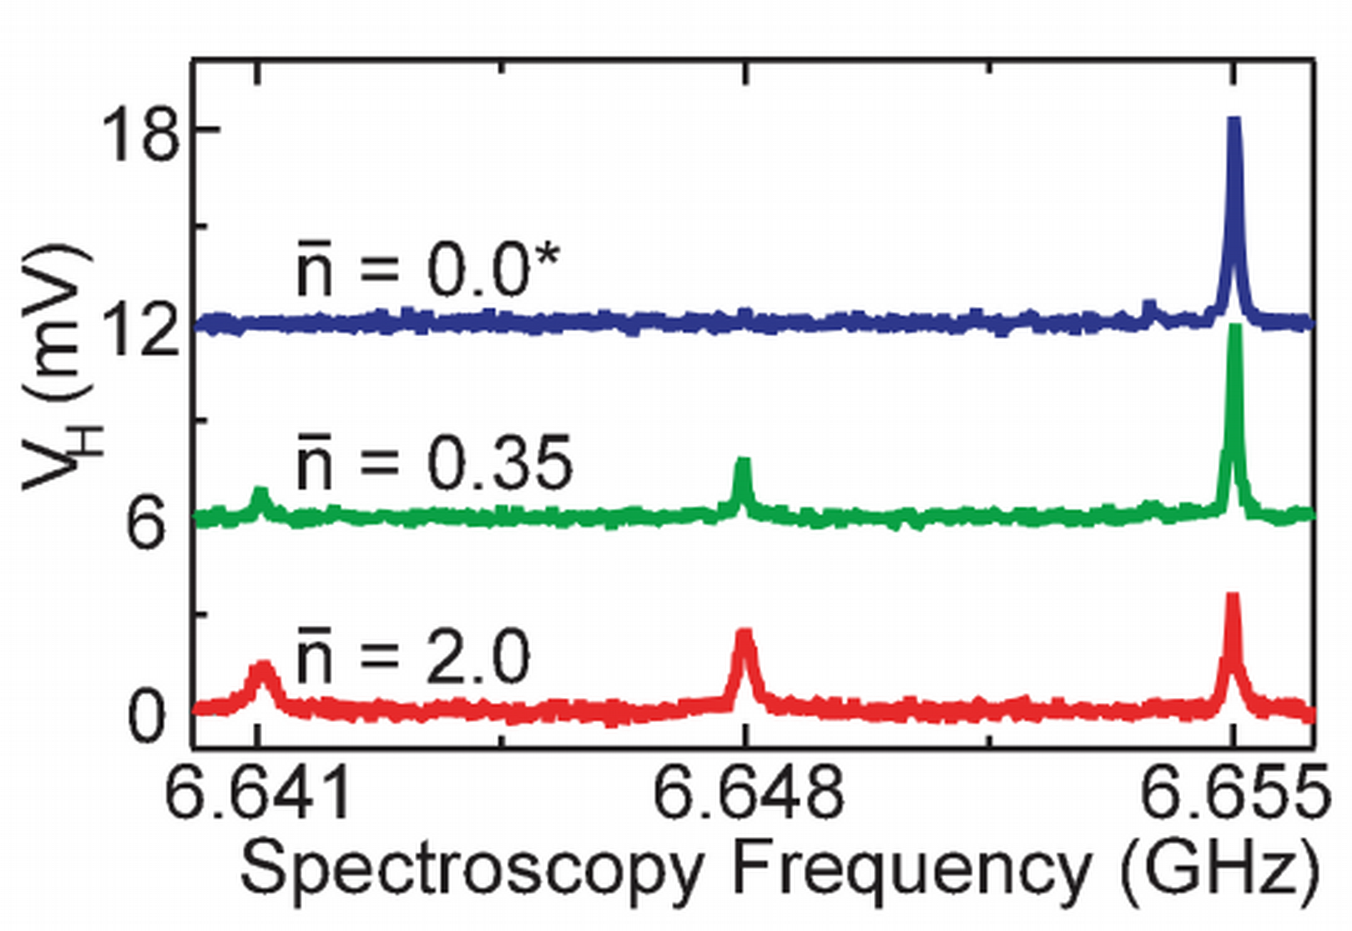

In [5]:
Image('Fig1c.png', width=420)

## Qubit dephasing due to photon noise

In [6]:
# Evolve qubit and calculate sx[n]
# nTh is the thermal photon number, n specifies the photon number subspace
def evolveT2(nTh, n):
    t2Theo = 1.0/(1.0/2.0/T1 + kappaR*(2.0*n*nTh + nTh + n))
    # Evolve the qubit 3 times the theoretical T2
    t2List = np.linspace(0, 3.0*t2Theo, numSteps)
    # Detune LO so that whole evolution contains 8 Ramsey fringes
    # Notice that the 2*n*chi shift for different n is taken into account
    deltaQ = 2.0*n*chi + 1.0/t2List[-1]*8.0*2.0*np.pi
    # Hamiltonian in the rotating frame of LO
    H = -deltaQ*sz/2.0 + chi*sz*adag*a
    # Collapse operator for Liouvillian
    c_ops = [np.sqrt(kappaR*(nTh+1.0))*a, np.sqrt(kappaR*nTh)*adag,
             np.sqrt(gammaQ)*sm]
    # Initialize cavity in nTh thermal photon state
    rhoR0 = qt.thermal_dm(N, nTh)
    # Initialize qubit on the equator of Bloch sphere
    psiQ0 = (qt.basis(2, 1) + qt.basis(2, 0))/np.sqrt(2)
    # Evolve the system using master equation solver
    rho0 = qt.tensor(rhoR0, psiQ0*psiQ0.dag())
    result = qt.mesolve(H, rho0, tlist=t2List, c_ops=c_ops, e_ops=[sx[n]])
    # Return time axis and <sx[n]>
    return t2List, np.real(result.expect[0])

# Fit t2 with data
def fitT2(tList, data):
    # Target function is cosine with exponential decay
    def fitFunc(t, amp, tau, freq, offset):
        return amp*np.cos(2.0*np.pi*freq*t)*np.exp(-t/tau)+offset
    # Initial guess for parameters
    ampGuess = np.max(data) - np.min(data)
    offsetGuess = data[-1]
    # Use FFT to guess the Ramsey fringe frequency
    freqList = rfftfreq(len(data))/(tList[1] - tList[0])
    peakFreq = freqList[np.argmax(np.abs(rfft(data)))]
    index = int(2.0/peakFreq/(tList[1] - tList[0]))
    tauGuess = -tList[index] / np.log((data[index] - data[0])/ampGuess + 1.0)
    # Fit T2
    pGuess = [ampGuess, tauGuess, peakFreq, offsetGuess]
    coeff, cov = curve_fit(fitFunc, tList, data, p0=pGuess)
    # Return T2 and fitted data
    return coeff[1], fitFunc(tList, *coeff)

nth = 1.0
# T2 data for zero-photon subspace
tlistZero, sxZero = evolveT2(nth, n=0)
# T2 data for on-photon subspace
tlistOne, sxOne = evolveT2(nth, n=1)

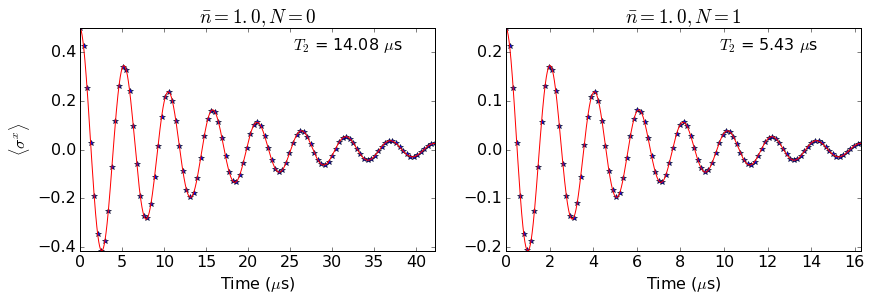

In [7]:
t2Zero, fitZero = fitT2(tlistZero, sxZero)
t2One, fitOne = fitT2(tlistOne, sxOne)

plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.plot(tlistZero[0::20], sxZero[0::20], '*', tlistZero, fitZero, 'r')
plt.ylabel(r'$\langle\sigma^x\rangle$')
plt.xlabel(r'Time ($\mu$s)')
plt.axis('tight')
plt.text(0.6, 0.9, r'$T_2$ = %.2f $\mu$s' % t2Zero,
         transform=plt.gca().transAxes)
plt.title(r'$\bar{n} = %.1f, N = 0$' % nth)

plt.subplot(122)
plt.plot(tlistOne[0::20], sxOne[0::20], '*', tlistOne, fitOne, 'r')
plt.axis('tight')
plt.text(0.6, 0.9, r'$T_2$ = %.2f $\mu$s' % t2One,
         transform=plt.gca().transAxes)
plt.xlabel(r'Time ($\mu$s)')
plt.title(r'$\bar{n} = %.1f, N = 1$' % nth)

When $|\chi|\gg \kappa, \gamma$, the photon shot noise dephasing rate is given by Eqn. (2) in the paper:
$$\gamma_\phi=\kappa(2\bar{n}N+\bar{n}+N),$$
where $\bar{n}$ is the thermal photon number and $N$ specifies the photon number subspace.

So $T_2 = [1/(2T_1)+\gamma_\phi]^{-1}=\left\{
\begin{array}{ll}
[1/(2T_1)+\bar{n}\kappa]^{-1} = 14.8\ \mu\text{s}, &N=0\\
[1/(2T_1)+(3\bar{n}+1)\kappa]^{-1} = 5.43\ \mu\text{s}, &N=1
\end{array}\right.$

If we plot $T_2^{-1}$ as a function of $\bar{n}$, we will see straight lines with slope $\kappa$ and $3\kappa$ for $N = 0, 1$ respectively.

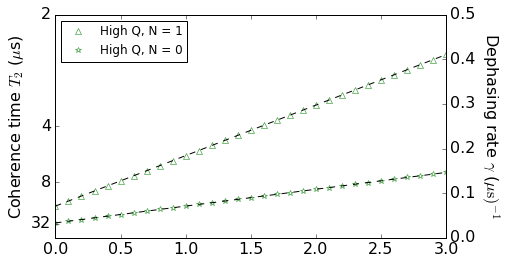

In [8]:
# T2 data for different nth and n are calucalated and stored in files
# See the comments in the data file for more details
filename = 'T2_ZeroPhoton.dat'
data = qt.file_data_read(filename)
nthList = data[0::2, 0]
t2Zero = []
for index in range(0, len(nthList)):
    t2, _ = fitT2(data[2*index, 1:], data[2*index+1, 1:])
    t2Zero.append(t2)

filename = 'T2_OnePhoton.dat'
data = qt.file_data_read(filename)
nthList = data[0::2, 0]
t2One = [1.0/(1.0/2.0/T1+kappaR)]
for index in range(1, len(nthList)):
    t2, _ = fitT2(data[2*index, 1:], data[2*index+1, 1:])
    t2One.append(t2)

plt.figure(figsize=(7, 4))
# Plot fitted t2
plt.plot(nthList, 1.0/np.array(t2One), '^', mec='g', mfc='none')
plt.plot(nthList, 1.0/np.array(t2Zero), '*', mec='g', mfc='none')
# Plot theoretical t2
plt.plot(nthList, 1.0/2.0/T1 + kappaR*(nthList), '--k')
plt.plot(nthList, 1.0/2.0/T1 + kappaR*(3.0*nthList + 1.0), '--k')
# Legend
plt.legend(['High Q, N = 1', 'High Q, N = 0'], loc='best', numpoints=1, fontsize=12)
# Left y axis
t2Ticks = [32, 8, 4, 2]
plt.yticks(1.0/np.array(t2Ticks), [str(t2) for t2 in t2Ticks])
plt.ylabel(r'Coherence time $T_2$ ($\mu$s)')
# Right y axis
ax1 = plt.gca()
ax1.twinx()
plt.ylim(ax1.get_ylim())
plt.ylabel(r'Dephasing rate $\gamma$ ($\mu\mathrm{s})^{-1}$', rotation=-90, va='bottom')

Below is Figure 2(a) in the the paper:

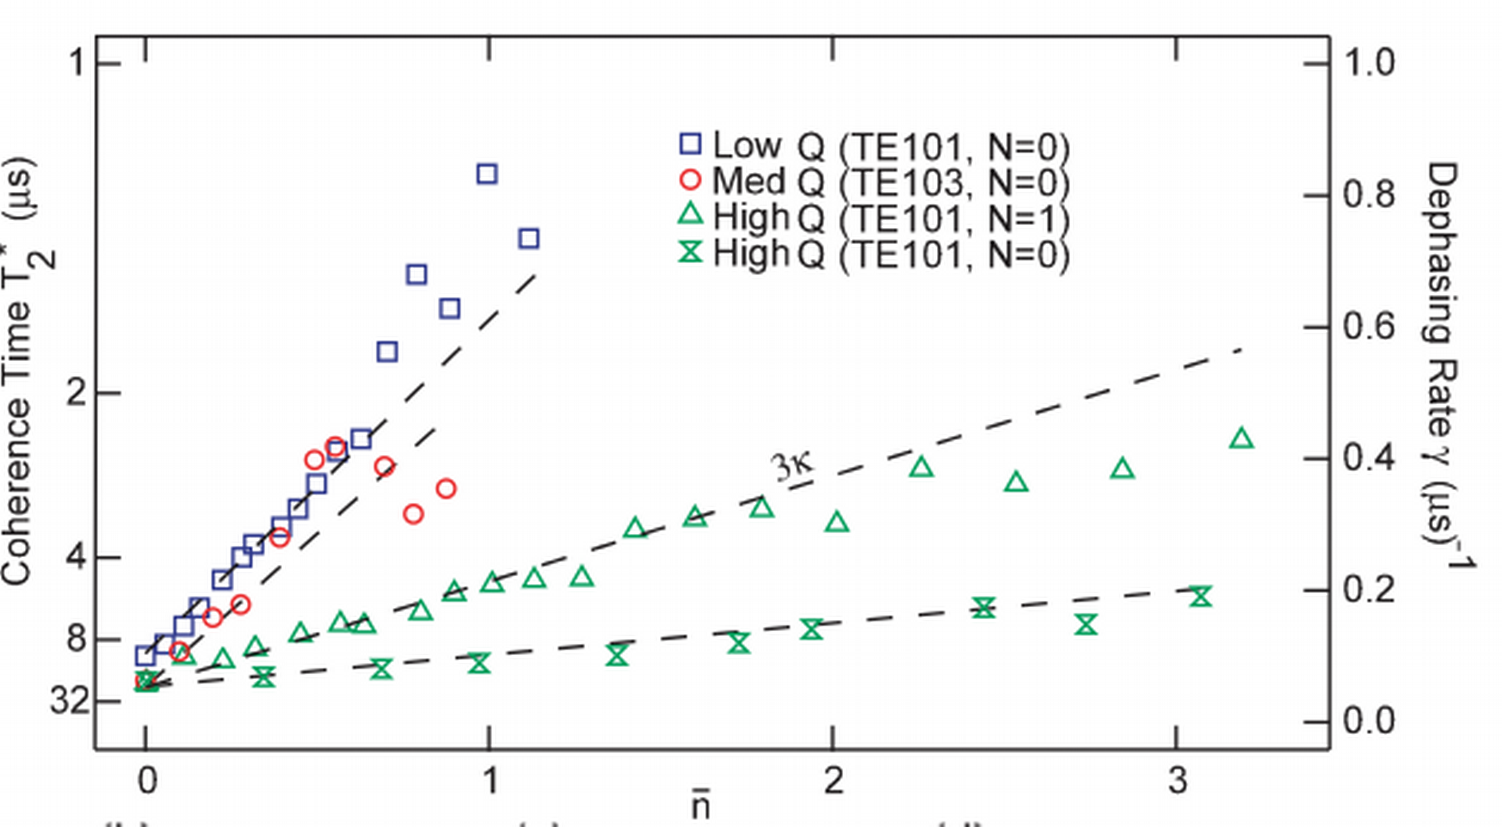

In [9]:
Image('Fig2a.png', width=500)

In [10]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,3.2.0.dev-05e6c1c
Numpy,1.11.0
SciPy,0.17.1
matplotlib,1.5.1
Cython,0.24
Number of CPUs,4
BLAS Info,INTEL MKL
IPython,4.2.0
Python,"2.7.10 (default, May 23 2015, 09:44:00) [MSC v.1500 64 bit (AMD64)]"
OS,nt [win32]
